**METHOD**
Analysis Plan
We aim to achieve two goals with our data:

- Understand what feature(s) is most important in heart failure deaths.
- Predict whether or not heart failure will occur given a person with information on these features.

**RandomForestClassifier and Feature Importance**

The machine learning tools we are using to accomplish these goals are a feature importance graph generated from a RandomForestClassifier. The graph will show which features have the most significance in determining whether a heart failure death will occur. A classifier is being used because a binary classification is being made, with the two options being death or survival. Were more categories being used, a regressor would be more appropriate. 

It will be important to note that the resulting feature importance graph does not imply any sort of direction, or in other words does not represent whether a feature is more likely to suggest a heart failure death versus survival. It simply shows which features have the largest impact on the outcome.

To address this gap in knowledge, correlation matrices will be produced in order to determine a negative or positive correlation between a given feature and a heart failure death. A positive correlation will indicate that the presence of some feature increases the likelihood of a heart failure death. A negative correlation indicates that the presence of some feature decreases the likelihood of a heart failure death. It is important to consider the context of individual features being considered, as the exact relationship is not always clear from a simple positive or negative correlation.

** discuss how feature importances already try to account for the correlations between features and see past that

**Confusion Matrix from RandomForestClassifier**



*from data and analysis plan:

Prediction & Discussions of Machine Learning Tools
There are two paths we can go with this: we can either use k-NN (K-Nearest Neighbors) or decision trees for this project. Our goal is to classify whether someone with these features is likely to have heart failure, so we woulld like to use classification-centered machine learning models. For this portion to work, we would likely have to split our dataset and perform a kFold in order to test the accuracy of our model; especially since this prediction model can mean life or death for some individuals, we would need this model to be as accurate as possible.*

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from copy import copy
from collections import Counter

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

from sklearn import tree

In [3]:
df_heart = pd.read_csv('heart_failure_clinical_records_dataset.csv') 
df_heart.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [4]:
# checking normalization: data needs to be scaled
df_heart.var()

age                         1.414865e+02
anaemia                     2.461224e-01
creatinine_phosphokinase    9.414586e+05
diabetes                    2.441023e-01
ejection_fraction           1.400635e+02
high_blood_pressure         2.286144e-01
platelets                   9.565669e+09
serum_creatinine            1.070211e+00
serum_sodium                1.946996e+01
sex                         2.286144e-01
smoking                     2.187156e-01
time                        6.023965e+03
DEATH_EVENT                 2.187156e-01
dtype: float64

In [5]:
# scale the data -- sets variance = 1
df_heart_scaled = copy(df_heart)
for col in df_heart_scaled.columns[:-1]:
  df_heart_scaled[col] = df_heart[col] / df_heart[col].std()

# death event should remained untouched, leave 0/1 values alone
df_heart_scaled.var()

age                         1.000000
anaemia                     1.000000
creatinine_phosphokinase    1.000000
diabetes                    1.000000
ejection_fraction           1.000000
high_blood_pressure         1.000000
platelets                   1.000000
serum_creatinine            1.000000
serum_sodium                1.000000
sex                         1.000000
smoking                     1.000000
time                        1.000000
DEATH_EVENT                 0.218716
dtype: float64

In [6]:
# correlation check: are any two variables correlated?
df_heart_scaled.iloc[:, :-1].corr()

# age and time appear to be correlated -- the higher the age, the lower the 
# amount of time before a follow-up (22.4%, highest correlation).

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
age,1.000000,0.088006,-0.081584,-0.101012,0.060098,0.093289,-0.052354,0.159187,-0.045966,0.065430,0.018668,-0.224068
anaemia,0.088006,1.000000,-0.190741,-0.012729,0.031557,0.038182,-0.043786,0.052174,0.041882,-0.094769,-0.107290,-0.141414
creatinine_phosphokinase,-0.081584,-0.190741,1.000000,-0.009639,-0.044080,-0.070590,0.024463,-0.016408,0.059550,0.079791,0.002421,-0.009346
diabetes,-0.101012,-0.012729,-0.009639,1.000000,-0.004850,-0.012732,0.092193,-0.046975,-0.089551,-0.157730,-0.147173,0.033726
ejection_fraction,0.060098,0.031557,-0.044080,-0.004850,1.000000,0.024445,0.072177,-0.011302,0.175902,-0.148386,-0.067315,0.041729
high_blood_pressure,0.093289,0.038182,-0.070590,-0.012732,0.024445,1.000000,0.049963,-0.004935,0.037109,-0.104615,-0.055711,-0.196439
platelets,-0.052354,-0.043786,0.024463,0.092193,0.072177,0.049963,1.000000,-0.041198,0.062125,-0.125120,0.028234,0.010514
serum_creatinine,0.159187,0.052174,-0.016408,-0.046975,-0.011302,-0.004935,-0.041198,1.000000,-0.189095,0.006970,-0.027414,-0.149315
serum_sodium,-0.045966,0.041882,0.059550,-0.089551,0.175902,0.037109,0.062125,-0.189095,1.000000,-0.027566,0.004813,0.087640
sex,0.065430,-0.094769,0.079791,-0.157730,-0.148386,-0.104615,-0.125120,0.006970,-0.027566,1.000000,0.445892,-0.015608


In [7]:
# K-NN Classifier WITHOUT PCA

# obtain required columns for analysis
k = 5
x_feat_list = df_heart_scaled.columns[:-1]
y_feat = 'DEATH_EVENT'

x = df_heart_scaled.loc[:, x_feat_list].values
y_true = df_heart_scaled.loc[:, y_feat].values

# create knn_classifier
knn_classifier = KNeighborsClassifier(n_neighbors=k)

# create stratified kfold object
kfold = StratifiedKFold(n_splits=5)

# create empty array to store predictions in
y_pred = copy(y_true)

for train_idx, test_idx in kfold.split(x, y_true):
    # build arrays which correspond to x, y train /test
    x_test = x[test_idx, :]
    x_train = x[train_idx, :]
    y_true_train = y_true[train_idx]

    # checking in: was the stratified kfold successful?
    print(f'trained on: {Counter(y_true_train)}')
    print(f'tested on: {Counter(y_true[test_idx])}')
    print('-' * 10)
    
    # fit happens "inplace", we modify the internal state of knn_classifier to remember all the training samples
    knn_classifier.fit(x_train, y_true_train)

    # estimate each penguin's species
    y_pred[test_idx] = knn_classifier.predict(x_test)


trained on: Counter({0: 163, 1: 76})
tested on: Counter({0: 40, 1: 20})
----------
trained on: Counter({0: 162, 1: 77})
tested on: Counter({0: 41, 1: 19})
----------
trained on: Counter({0: 162, 1: 77})
tested on: Counter({0: 41, 1: 19})
----------
trained on: Counter({0: 162, 1: 77})
tested on: Counter({0: 41, 1: 19})
----------
trained on: Counter({0: 163, 1: 77})
tested on: Counter({0: 40, 1: 19})
----------


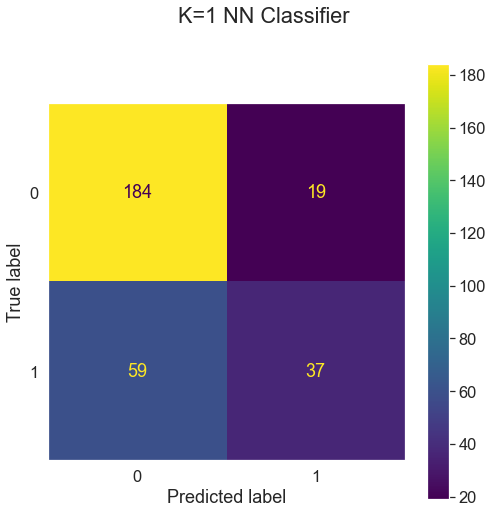

In [8]:
# build confusion matrix
conf_mat = confusion_matrix(y_true=y_true, y_pred=y_pred)
conf_mat_disp = ConfusionMatrixDisplay(conf_mat, display_labels=np.unique(y_true))

# plot confusion matrix & adjust size
sns.set(font_scale=1.5)
conf_mat_disp.plot()
plt.suptitle('K=1 NN Classifier')
plt.gcf().set_size_inches(8, 8)
plt.grid(False)

In [9]:
# the confusion matrix doesn't look too good...
# seems like people with death_event are showing up as not having death_event

accuracy_score(y_true, y_pred)

0.7391304347826086